## import libraries
Before running this, please install pyMAGIQ (python-based MAGnetotelluric Impedance matrix Qualifier) using setup.py.
> python setup.py install

In [1]:
import csv
import sys
import os
import json
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Flatten, Conv1D
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam, Nadam,Adamax
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.models import model_from_json
from keras.utils import plot_model
from keras.utils import np_utils

# Local Import
import pyMAGIQ

/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# global variables
### frequency for basic USArray
from shorter period to longer period

In [2]:
freq_interp = [  1.367187E-01, 1.093750E-01, 8.593753E-02, 6.640627E-02, 5.078124E-02, 3.906250E-02,
        3.027344E-02, 2.343750E-02, 1.855469E-02, 1.464844E-02, 1.171875E-02, 9.765625E-03,
        7.568361E-03, 5.859374E-03, 4.638671E-03, 3.662109E-03, 2.929688E-03, 2.441406E-03,
        1.892090E-03, 1.464844E-03, 1.159668E-03, 9.155271E-04, 7.324221E-04, 6.103516E-04,
        4.425049E-04, 3.204346E-04, 2.136230E-04, 1.373291E-04, 8.392331E-05, 5.340577E-05]

## parameter of neural network
* nunits: number of nodes for each
* nrate : number of rating for impedance tensor
* nfreq : number of frequencies for inputs
* ndata : number of data used for impecance tensor (Apparent resistivities, phases and those errorbar)
* ncomp : number of components used for impecance tensor (xy and yx)
* epochs : number of iterations
* batch_size : number of samples that going to be propagated through the network.

In [3]:
nunits = 10
nrate = 5
nfreq = 30
ndata = 4
ncomp = 2
epochs = 200
batch_size = 32


## Loading the data

Raw files downloaded from:
- http://ds.iris.edu/spud/emtf

and saved training data in ~/GIC/survey/ZML/data/train, test data in ~/GIC/survey/ZML/data/test. Test data is used for the validation, so training and test data have to have rating information in xml file. Please save unrated data in ~/GIC/survey/ZML/data/unrated. Unrated data does not have rating information in xml file.

In [4]:
# Set directory to read impedance tensor in xml data format

# Set the file paths appropriately for your own situation
datadir = '/Users/nimamura/GIC/survey/ZML/data'
# datadir = '/home/server/pi/homes/nimamura/GIC/survey/ZML/data'

traindir    = datadir + '/train'
testdir     = datadir + '/test'
X_trainpath = datadir + '/X_train.csv'
X_testpath  = datadir + '/X_test.csv'
y_trainpath = datadir + '/y_train.csv'
y_testpath  = datadir + '/y_test.csv'
rate_trainpath  = datadir + '/rate_train.csv'
rate_testpath  = datadir + '/rate_test.csv'
SiteIDpath  = datadir + '/siteID_train.csv'


In [5]:
# list in training directory and test directory
trainlists = sorted( [f for f in os.listdir(traindir) if not f.startswith('.')] )
testlists  = sorted( [f for f in os.listdir(testdir) if not f.startswith('.')] )

# number of lists
nMTtrain = len(trainlists)
nMTtest  = len(testlists)

## Reading and saving data
* X_train : impedance tensor of training datasets
* y_train : rating of training datasets
* X_test  : impedance tensor of test datasets
* y_test  : rating of test datasets


In [6]:
# read X and y data from xml file
if not os.path.isfile(X_trainpath):
    # read X_train and y_train
    X_train = np.zeros((nMTtrain,nfreq,ndata*ncomp),dtype=np.float32)    # Note that real value
    y_train = np.zeros((nMTtrain,),dtype=np.int)

    X_train, y_train, rate_train, SiteID = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getXYdataset(X_train,y_train,nfreq,traindir,trainlists,freq_interp)

    # read X_test and y_test
    X_test = np.zeros((nMTtest,nfreq,ndata*ncomp),dtype=np.float32)    # Note that real value
    y_test = np.zeros((nMTtest,),dtype=np.int)

    X_test, y_test, rate_test, SiteID_test = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getXYdataset(X_test,y_test,nfreq,testdir,testlists,freq_interp)

    # change shape to fit it to deep learning
    X_train = X_train.reshape(len(X_train),nfreq*ndata*ncomp).astype('float32')
    X_test  = X_test.reshape(len(X_test),nfreq*ndata*ncomp).astype('float32')

    # save X and y data in csv format. You don't have to read EDI files again
    # np.savetxt( X_trainpath, X_train, fmt="%.5e", delimiter=',')
    # np.savetxt( X_testpath,  X_test, fmt="%.5e", delimiter=',')
    np.savetxt( X_trainpath, X_train, delimiter=',')
    np.savetxt( X_testpath,  X_test, delimiter=',')
    np.savetxt( y_trainpath, y_train, fmt='%d', delimiter=',')
    np.savetxt( y_testpath,  y_test, fmt='%d', delimiter=',')
    np.savetxt( rate_trainpath, rate_train, fmt='%d', delimiter=',')
    np.savetxt( rate_testpath,  rate_test, fmt='%d', delimiter=',')

    with open(SiteIDpath,'w') as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in SiteID:
            writer.writerow([val])
# loading saved X and y if csv file exists
else:
    X_train = np.loadtxt( X_trainpath , dtype=np.float32, delimiter=",")
    X_test  = np.loadtxt( X_testpath  , dtype=np.float32, delimiter=",")
    y_train = np.loadtxt( y_trainpath , dtype=np.int, delimiter=",")
    y_test  = np.loadtxt( y_testpath  , dtype=np.int, delimiter=",")
    rate_train = np.loadtxt( rate_trainpath , dtype=np.int, delimiter=",")
    rate_test  = np.loadtxt( rate_testpath  , dtype=np.int, delimiter=",")


/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: loadtxt: Empty input file: "/Users/nimamura/GIC/survey/ZML/data/X_test.csv"
/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: loadtxt: Empty input file: "/Users/nimamura/GIC/survey/ZML/data/y_test.csv"
/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: loadtxt: Empty input file: "/Users/nimamura/GIC/survey/ZML/data/rate_test.csv"


In [7]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nrate)
y_test  = np_utils.to_categorical(y_test, nrate)


In [8]:
y_train.shape

(1033, 5)

## Now create deep learning model

In [9]:
# add layers
reg_val = 0.0001
reg_ker = 0.001

# initialize model
model = Sequential()

# add layers
model.add(Dense( activation='relu', units=nunits,
                 kernel_regularizer=regularizers.l1(reg_ker),
                 input_dim=ndata*ncomp*nfreq))

model.add(Dense( activation='relu',
                 kernel_regularizer=regularizers.l1(reg_val),
                 units=nunits ))

model.add(Dense( activation='softmax', units=nrate,
                 kernel_regularizer=regularizers.l1(reg_ker),
                 name='preds' ))



In [10]:
# # add layers
# reg_val = 0.0001
# reg_ker = 0.001

# # initialize model
# model = Sequential()

# # add layers
# model.add(Dense( activation='relu', units=nunits*2,
#                  kernel_regularizer=regularizers.l1(reg_ker),
#                  input_dim=ndata*ncomp*nfreq))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits*2 ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits*2 ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits*2 ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits ))

# model.add(Dense( activation='relu',
#                  kernel_regularizer=regularizers.l1(reg_val),
#                  units=nunits ))

# model.add(Dense( activation='softmax', units=nrate,
#                  kernel_regularizer=regularizers.l1(reg_ker),
#                  name='preds' ))




## Setting optimization method

In [11]:
# setting optimization
model.compile(loss="categorical_crossentropy",
              # optimizer=Nadam(),
              optimizer=Adamax(),
              # optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
              # optimizer=Adam(),
              metrics=["accuracy"])

model.summary()
# learning parameters
history = model.fit(X_train, y_train, epochs=epochs,
                     validation_split=0.1, batch_size=batch_size)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                2410      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
preds (Dense)                (None, 5)                 55        
Total params: 2,575
Trainable params: 2,575
Non-trainable params: 0
_________________________________________________________________
Train on 929 samples, validate on 104 samples
Epoch 1/200
929/929 [==============================] - 0s 303us/step - loss: 1.6849 - acc: 0.3434 - val_loss: 1.5873 - val_acc: 0.3462
Epoch 2/200
929/929 [==============================] - 0s 95us/step - loss: 1.5361 - acc: 0.3434 - val_loss: 1.5092 - val_acc: 0.3462
Epoch 3/200
929/929 [==============================] - 0s 99us/step - loss: 1.4807 - acc:

## Save model and data 

In [12]:
# plot_model returns error when using python 3, so commented out.
# save model in png file
#plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

# save model
model_json = model.to_json()
with open("model.json",mode='w') as f:
    f.write(model_json)
    
# save weight
model.save_weights('weights.hdf5')


## Plot convergence history

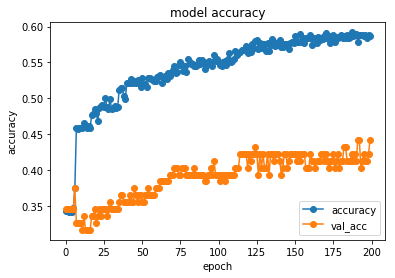

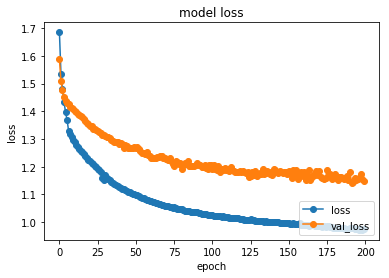

In [13]:
# plot history of convergence
pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.plot_history(history)

## Reading saved weights.hdf5

In [14]:
import h5py

# inverse of freq_interp
period = [ 1.0/x for x in freq_interp ]

filename = 'weights.hdf5'
f = h5py.File(filename, 'r')
# List all groups
dense1 = f['dense_1']['dense_1']
bias   = dense1['bias:0']
kernel = dense1['kernel:0']
# convert h5py dataset to ndarray
dset = kernel[()]

nnode = len(dset[0])
print(nnode)

Wmatrix = np.zeros( (ncomp*ndata,nfreq,nnode) ,dtype=np.float32)
for inode in range(nnode):
    tmp = dset[:,inode]
    Wmatrix[:,:,inode] = tmp.reshape(ncomp*ndata,nfreq,order='F')


10


## Plot Wmatrix

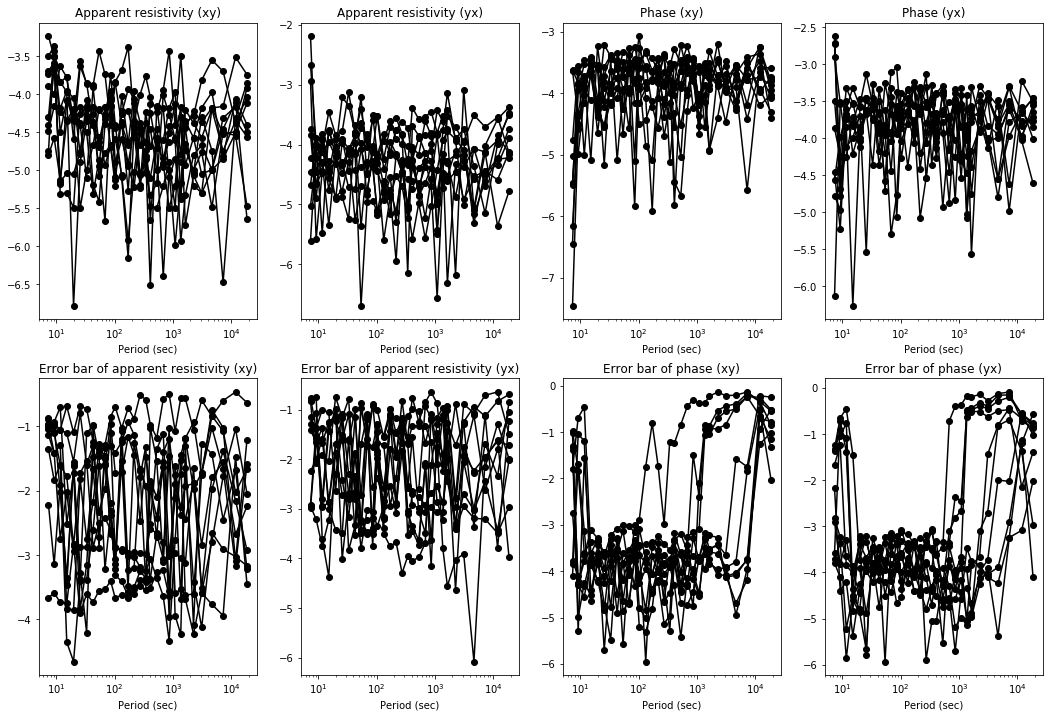

In [15]:
def plot_line_dset(Wmatrix):

    nnode = Wmatrix.shape[2]

    plt.figure(figsize=(18,12))

    for i in range(8):
        if i%2 == 0:
            comp = '(xy)'
        else:
            comp = '(yx)'

        if i//2 == 0:
            data = 'Apparent resistivity'
        elif i//2 == 1:
            data = 'Phase'
        elif i//2 == 2:
            data = 'Error bar of apparent resistivity'
        elif i//2 == 3:
            data = 'Error bar of phase'

        plt.subplot(2,4,i+1)
        string = data + ' ' + comp
        plt.title(string)
        for inode in range(nnode):
            W = np.log10( np.abs( Wmatrix[i,:,inode] ) )
            plt.semilogx(period,W,'k-o')
            plt.xlabel('Period (sec)')

    plt.savefig('./cnn_group.eps',format='eps')
    plt.show()

plot_line_dset(Wmatrix)


## Apply model to predict Canadian datasets
Setup directory first

In [16]:
unrateddir       = datadir + '/unrated'
X_unratedpath    = datadir + '/X_unrated.csv'
y_unratedpath    = datadir + '/y_unrated.csv'
rate_unratedpath = datadir + '/rate_unrated.csv'
SiteIDpath_unrated = datadir + '/siteID_unrated.csv'

unratedlists = sorted( [f for f in os.listdir(unrateddir) if not f.startswith('.')] )

nMTunrated  = len(unratedlists)


## read X_unrated

In [17]:
# read X_unrated
X_unrated = np.zeros((nMTunrated,nfreq,ndata*ncomp),dtype=np.float32)    # Note that real value
X_unrated,SiteID = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getX_unrated(X_unrated,nfreq,unrateddir,unratedlists,freq_interp)

# convert shape
X_unrated = X_unrated.reshape(len(X_unrated),nfreq*ndata*ncomp).astype('float32')

import csv 

# save X and y data in csv format. You don't have to read EDI files again
np.savetxt( X_unratedpath,  X_unrated, delimiter=',')
with open(SiteIDpath_unrated,'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in SiteID:
        writer.writerow([val])

MT_TF_CAFE-MT.CAF02.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF04.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF06.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF09.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF11.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF13.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
skip it! IndexError when reading XML file  MT_TF_CAFE-MT.CAF13.2010
MT_TF_CAFE-MT.CAF15.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_CAFE-MT.CAF18.2010
Use Hx orientation as a declination angle, instead of original decl

## read model and apply it to X_unrated

In [18]:
# read model
model = model_from_json(open('model.json').read())

# read weights
model.load_weights('weights.hdf5')

model.summary()

# setting optimization
model.compile(loss="categorical_crossentropy",
              optimizer=Adamax(),
              metrics=["accuracy"])

#evaluate unrated
y_est  = model.predict(X_unrated)

np.savetxt( y_unratedpath, y_est, delimiter=',' )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                2410      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
preds (Dense)                (None, 5)                 55        
Total params: 2,575
Trainable params: 2,575
Non-trainable params: 0
_________________________________________________________________


## Plot rated Map US
define function first

In [19]:
from mpl_toolkits.basemap import Basemap
import xml.etree.ElementTree as ET

#************************************************************************/
def read_rate(path):

    ratelist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            maxindex = np.argmax(row) + 1
            ratelist.append( maxindex )

    return ratelist

#************************************************************************/
def read_rate_ytrain(path):

    ratelist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            ratelist.append( int(row[0])+1 )

    return ratelist

#************************************************************************/
def read_siteID(path):

    siteIDlist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            siteIDlist.append(row[0])

    return siteIDlist

#************************************************************************/
def read_lonlat(datadir,siteIDlist,target):

    latlist = []
    lonlist = []
    ratinglist = []

    for siteID in siteIDlist:
        fname = siteID.replace('MT_TF_','') + '.xml'
        XMLpath = datadir + '/' + target + '/' + siteID + '/' + fname

        tree = ET.parse(XMLpath)
        root = tree.getroot()

        # find latitude
        for children in root.iter('Latitude'):
            lat = float(children.text)
        latlist.append(lat)

        # find longitude
        for children in root.iter('Longitude'):
            lon = float(children.text)
        lonlist.append(lon)

    return latlist,lonlist

#************************************************************************/
def plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist):

    sc = 12

    fig = plt.figure(figsize=(16,9), dpi=150, facecolor='w', edgecolor='k')

    # Map
    m = Basemap(projection='merc',
                     resolution='l',
                     llcrnrlon=xmin,
                     llcrnrlat=ymin,
                     urcrnrlon=xmax,
                     urcrnrlat=ymax)

    m.drawcoastlines(color='lightgray')
    m.drawcountries(color='lightgray')
    m.fillcontinents(color='white', lake_color='#eeeeee', zorder = 0);
    m.drawmapboundary(fill_color='#eeeeee')

    cm = plt.cm.get_cmap('cool',5)
    x,y = m(lonlist, latlist)
    sca= m.scatter(x,y,c=ratelist, s=sc,cmap=cm)

    plt.colorbar(sca, shrink=0.6)
    plt.clim(0.5,5.5)
    fig.savefig(datadir+'/image.eps',format='eps')
    plt.show()


/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


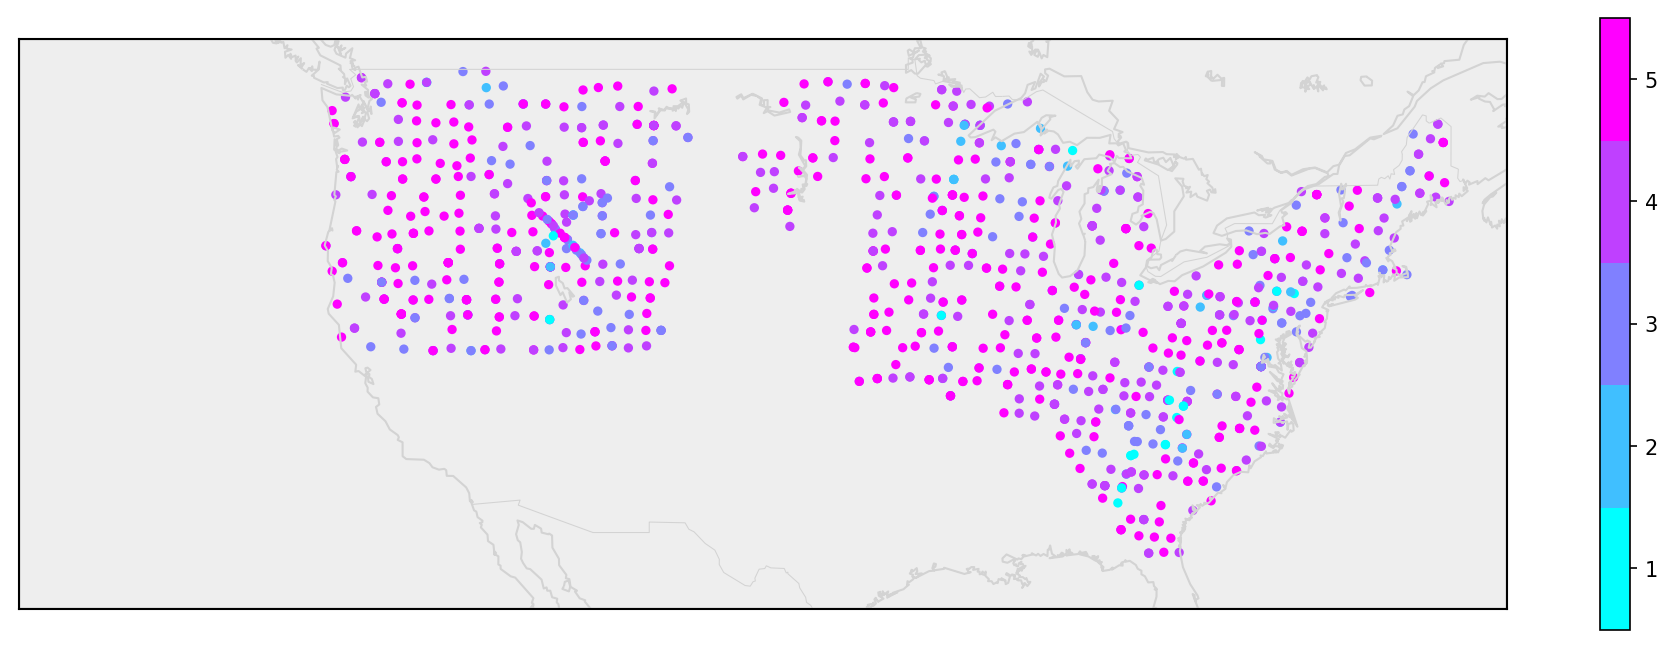

In [19]:
target='train'

xmin = -140
xmax = -65.0
ymin = 28.0
ymax = 50.0

# read rate
ratelist = read_rate_ytrain(y_trainpath)

# read site ID
siteIDlist = read_siteID(SiteIDpath)

latlist,lonlist = read_lonlat(datadir,siteIDlist,target)

plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist)


## Plot rated Map Canada

/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/nimamura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


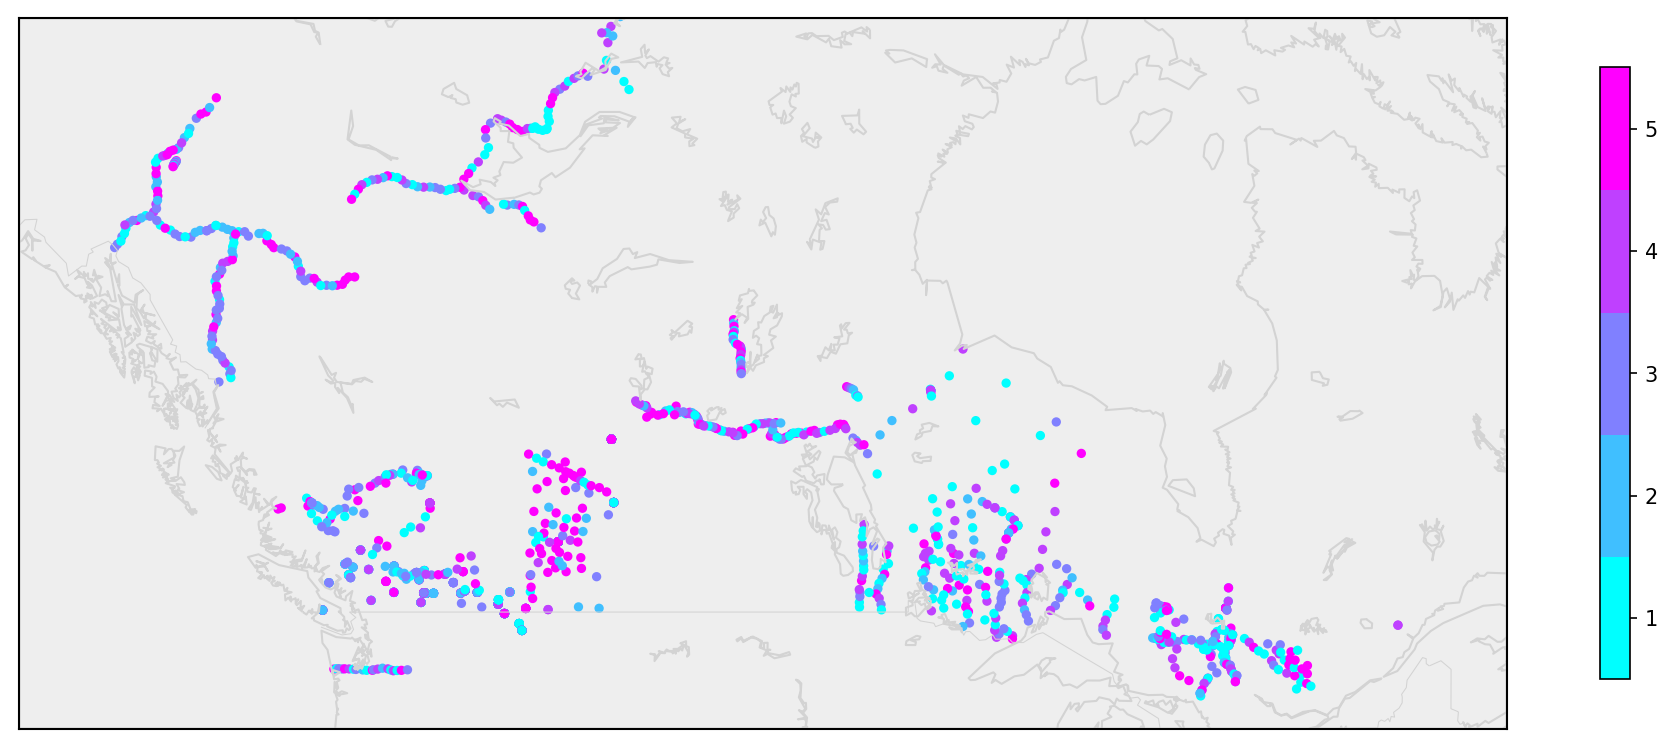

In [20]:
target = 'unrated'

xmin = -140
xmax = -65.0
ymin = 45.0
ymax = 65.0

# read rate
ratelist = read_rate(y_unratedpath)

# read site ID
siteIDlist = read_siteID(SiteIDpath_unrated)

latlist,lonlist = read_lonlat(datadir,siteIDlist,target)

plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist)



## Check estimated Apparent resistivity using unrated datasets
define function first

In [21]:
import matplotlib.gridspec as gridspec

#************************************************************************/
def plot_Z(alldata,targetSiteID):

    fig = plt.figure(figsize=(14,12))
    outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

    for i in range(9):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        # target Site ID name
        target = targetSiteID[i]

        # read variable
        Zapp_xy     = alldata[target]['Zapp_xy']
        Zapp_err_xy = alldata[target]['Zapp_err_xy']
        Zphs_xy     = alldata[target]['Zphs_xy']
        Zphs_err_xy = alldata[target]['Zphs_err_xy']

        Zapp_yx     = alldata[target]['Zapp_yx']
        Zapp_err_yx = alldata[target]['Zapp_err_yx']
        Zphs_yx     = alldata[target]['Zphs_yx']
        Zphs_err_yx = alldata[target]['Zphs_err_yx']

        period      = alldata[target]['period']
        rate        = alldata[target]['rate']

        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            ax.grid()
            title_str = 'Rating: ' + str(rate)
            if j == 0:
                ax.set_title(title_str)
                ax.errorbar(period,Zapp_xy,yerr=Zapp_err_xy,fmt='o',mfc='none',capsize=4,label='xy')
                ax.errorbar(period,Zphs_yx,yerr=Zphs_err_yx,fmt='o',mfc='none',capsize=4,label='yx',c='r')
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim([1.E-0,1.E+5])
                # ax.set_ylim([1.E-1,1.E+4])
                # ax.legend()

            else:
                ax.errorbar(period,Zphs_xy,yerr=Zphs_err_xy,fmt='o',mfc='none',capsize=4)
                ax.errorbar(period,Zphs_yx,yerr=Zphs_err_yx,fmt='o',mfc='none',capsize=4,c='r')
                ax.set_xscale('log')
                ax.set_xlim([1.E-0,1.E+5])
                ax.set_ylim([0,90])
                ax.set_yticks([0,30,60,90])
                # ax.grid()

            fig.add_subplot(ax)

    plt.savefig('./AppRes.eps',format='eps')
    plt.show()

MT_TF_Lithoprobe.LIT111.1990
Use Hx orientation as a declination angle, instead of original declination
reading Z.VAR
MT_TF_UofAlberta.sa175.2010
reading Z.VAR
MT_TF_Lithoprobe.WST139.1998
reading Z.VAR
MT_TF_Lithoprobe.ABT310.1993-1996
reading Z.VAR
MT_TF_Lithoprobe.ABT301.1993-1996
reading Z.VAR
MT_TF_Lithoprobe.ABT006.1993-1996
reading Z.VAR
MT_TF_UofAlberta.bc310.2009
reading Z.VAR
MT_TF_Lithoprobe.WST004.1998
reading Z.VAR
MT_TF_CAFE-MT.CAF11.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV


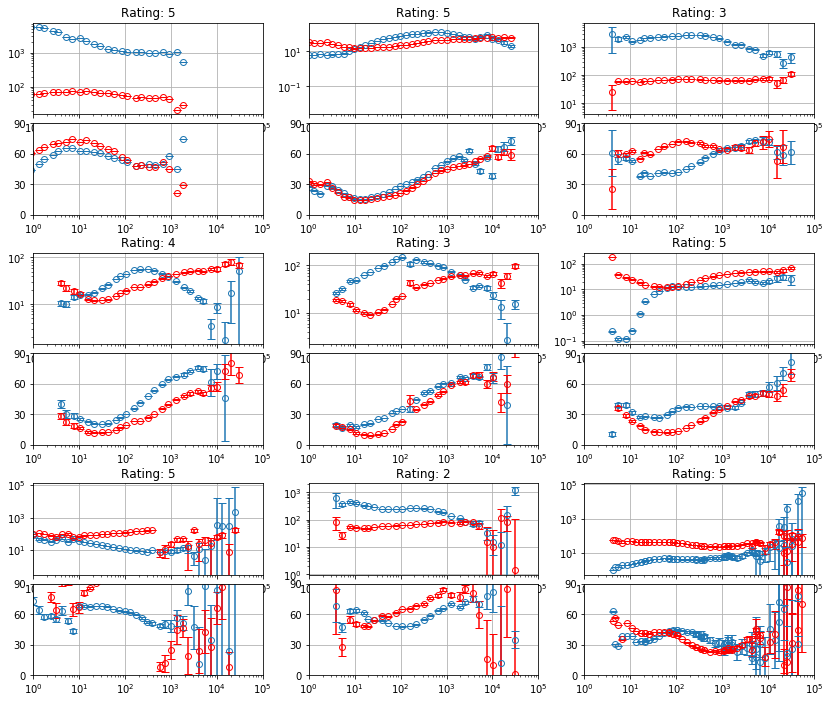

In [22]:
# ID list to plot
# Change this list as you like
targetSiteID_unrated = ['MT_TF_Lithoprobe.LIT111.1990',
                'MT_TF_UofAlberta.sa175.2010',
                'MT_TF_Lithoprobe.WST139.1998',
                'MT_TF_Lithoprobe.ABT310.1993-1996',
                'MT_TF_Lithoprobe.ABT301.1993-1996',
                'MT_TF_Lithoprobe.ABT006.1993-1996',
                'MT_TF_UofAlberta.bc310.2009',
                'MT_TF_Lithoprobe.WST004.1998',
                'MT_TF_CAFE-MT.CAF11.2010' ]

target = 'unrated'

alldata = {}

# read rate
ratelist = read_rate(y_unratedpath)

# change variable name
targetSiteID = targetSiteID_unrated

siteIDlist = read_siteID(SiteIDpath_unrated)

for i in range(len(targetSiteID)):
    print( targetSiteID[i] )
    # initialize dictionary for current MT site
    alldata[targetSiteID[i]] = {}
    siteIndex = siteIDlist.index( targetSiteID[i] )

    MTdir = datadir + '/' + target + '/' + targetSiteID[i]

    # filename of xml
    XMLlist = sorted( [f for f in os.listdir(MTdir) if f.endswith('xml')] )

    # path to xml and edi file
    XMLpath = MTdir + '/' + XMLlist[0]

    period, xmldata, Zapp, Zapp_err, Zphs, Zphs_err = pyMAGIQ.gicpy.iofiles.io.readXML(XMLpath,True)

    rate = ratelist[siteIndex]

    Zapp2 = Zapp[:,1:2].flatten().tolist()
    Zapp_err2 = Zapp_err[:,1:2].flatten().tolist()
    Zphs2 = Zphs[:,1:2].flatten().tolist()
    Zphs_err2 = Zphs_err[:,1:2].flatten().tolist()

    Zapp3 = Zapp[:,2:3].flatten().tolist()
    Zapp_err3 = Zapp_err[:,2:3].flatten().tolist()
    Zphs3 = Zphs[:,2:3].flatten().tolist()
    Zphs_err3 = Zphs_err[:,2:3].flatten().tolist()

    alldata[targetSiteID[i]]['Zapp_xy']     = Zapp2
    alldata[targetSiteID[i]]['Zapp_err_xy'] = Zapp_err2
    alldata[targetSiteID[i]]['Zphs_xy']     = Zphs2
    alldata[targetSiteID[i]]['Zphs_err_xy'] = Zphs_err2

    alldata[targetSiteID[i]]['Zapp_yx']     = Zapp3
    alldata[targetSiteID[i]]['Zapp_err_yx'] = Zapp_err3
    alldata[targetSiteID[i]]['Zphs_yx']     = Zphs3
    alldata[targetSiteID[i]]['Zphs_err_yx'] = Zphs_err3

    alldata[targetSiteID[i]]['period']      = period
    alldata[targetSiteID[i]]['rate']        = rate

plot_Z(alldata,targetSiteID)
